# Benchmarks

## Initialize

In [1]:
#library(Rmisc)
library(dtplyr)
library(tidyverse)
library(glue)
library(arrow)
library(patchwork)
library(data.table)
library("jsonlite")
library(ggthemes)

Warning message:
“package ‘dtplyr’ was built under R version 4.0.3”
Warning message:
“package ‘tidyverse’ was built under R version 4.0.3”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.0.5”
Warning message:
“package ‘tibble’ was built under R version 4.0.5”
Warning message:
“package ‘tidyr’ was built under R version 4.0.3”
Warning message:
“package ‘readr’ was built under R version 4.0.5”
Warning message:
“package ‘purrr’ was built under R version 4.0.3”
Warning message:
“package ‘dplyr’ was built under R version 4.0.5”
Warning message:
“package ‘stringr’ was built under R version 4.0.5”
Warning message:
“package ‘forcats’ was built under R version 4.0.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::f

In [2]:
if (grepl("sc", Sys.info()[["nodename"]], fixed=TRUE)) {
    base_path = "/sc-projects/sc-proj-ukb-cvd"
} else {
    base_path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS"}
print(base_path)

project_label = "22_retina_phewas"
project_path = glue("{base_path}/results/projects/{project_label}")
figure_path = glue("{project_path}/figures")
output_path = glue("{project_path}/data")

experiment = '230426'
experiment_path = glue("{output_path}/{experiment}")
print(experiment_path)

[1] "/sc-projects/sc-proj-ukb-cvd"
/sc-projects/sc-proj-ukb-cvd/results/projects/22_retina_phewas/data/230426


In [3]:
base_size = 8
title_size = 10
facet_size = 9
geom_text_size=3
theme_set(theme_classic(base_size = base_size) + 
          theme(strip.background = element_blank(), plot.title=element_text(size=title_size, hjust=0), 
                strip.text.x = element_text(size = facet_size),axis.title=element_text(size=10), axis.text=element_text(size=8, color="black"),
                legend.position="bottom", axis.line = element_line(size = 0.2), axis.ticks=element_line(size=0.2), panel.grid.major.y=element_line()))

In [4]:
endpoint_defs = arrow::read_feather(glue("{output_path}/phecode_defs_220306.feather")) %>% arrange(endpoint)
endpoints_md = fread(glue("{experiment_path}/endpoints.csv"), colClasses=c("phecode"="character"))
endpoints = sort(endpoints_md$endpoint)

In [5]:
endpoint_map = endpoint_defs$phecode_string
names(endpoint_map) =  endpoint_defs$endpoint
endpoint_order = (endpoint_defs %>% arrange(as.numeric(phecode)))$endpoint

In [6]:
endpoint_selection = c(
    # generally very important
    "phecode_202", # Diabetes mellitus
    "phecode_401", #Hypertension"
    "phecode_404", # Ischemic heart disease
    "phecode_404-1", # Myocardial infarction [Heart attack]
    "phecode_431-11", # Cerebral infarction [Ischemic stroke]
    "phecode_424", # Heart failure
    
    #"phecode_059-1", # COVID 19
    
    "phecode_468", # Pneumonia
    "phecode_474", # Chronic obstructive pulmonary disease [COPD]
    
    "phecode_286-2", #	Major depressive disorder
    "phecode_324-11", #Parkinson's Disease
    "phecode_328", # Dementias and cerebral degeneration

    "phecode_164", # Anemia
    "phecode_726-1", # Osteoporosis
    "phecode_371", # Cataract
    
    #"phecode_374-3", # Retinal vascular changes and occlusions
    "phecode_374-42", # Diabetic retinopathy
    "phecode_374-5", # Macular degeneration
    "phecode_375-1", # Glaucoma
    #"phecode_388" # Blindness and low vision 
    
    "phecode_103", # Malignant neoplasm of the skin
    "phecode_101", # Malignant neoplasm of the digestive organs
    "phecode_102", # LUNG CANCER
    
    "phecode_583", # Chronic kidney disease
    "phecode_542", # Chronic liver disease and sequelae
    "OMOP_4306655" # All-Cause Death
    
    #"phecode_440-3", # Pulmonary embolism
    #"phecode_468-1",	#Viral pneumonia
    
    #"phecode_460-2",	#Acute lower respiratory infection
    #"phecode_665", # Psoriasis
    #"phecode_121", # Leukemia
    #"phecode_705-1", # Rheumatoid arthritis

)

endpoints_common = c(
   'phecode_164', #Anemia
 'phecode_705-1', #Rheumatoid arthritis
 'phecode_328', #Dementias and cerebral degeneration
 'phecode_328-1', #Alzheimer's disease
 'phecode_401', #Hypertension
 'phecode_202', #Diabetes mellitus
 'phecode_416-21', #Atrial fibrillation
 'phecode_404-1', #Myocardial infarction [Heart attack]
 'phecode_424', #Heart failure
 'phecode_468', #Pneumonia
 'phecode_474', #Chronic obstructive pulmonary disease [COPD]
 'phecode_583', #Chronic kidney disease
 'OMOP_4306655' #All-Cause Death
    )
    
endpoints_cardio = c(
#     'phecode_431-11', #  "Cerebral infarction [Ischemic stroke]",
#     'phecode_404', #  "Ischemic heart disease",
#     'phecode_404-1', #  "Myocardial infarction [Heart attack]", # intervention
#     'phecode_424', #  "Heart failure", # intervention
#      'OMOP_4306655', #  "All-Cause Death", # intervention
#     'phecode_420', #  "Cardiac arrest", # intervention
#     'phecode_059-1' # COVID
   
# )


    'phecode_431-11', #  "Cerebral infarction [Ischemic stroke]",
    'phecode_404', #  "Ischemic heart disease",
    'phecode_404-1', #  "Myocardial infarction [Heart attack]", # intervention
    'phecode_424', #  "Heart failure", # intervention
    'OMOP_4306655' #  "All-Cause Death", # intervention
#     'phecode_420' #  "Cardiac arrest", # intervention 
#     "phecode_375-1", # Glaucoma
#     "phecode_374-42", # Diabetic retinopathy
#     "phecode_202", # Diabetes mellitus
#     "phecode_401",	#Hypertension"  
#     "phecode_103", # Malignant neoplasm of the skin
#    'phecode_059-1' #  "COVID",
    )

endpoints_eye= c(
    'phecode_374-5', #Macular degeneration
 'phecode_374-51', #Age-related macular degeneration
 'phecode_374-42', #Diabetic retinopathy
 'phecode_371', #Cataract
 'phecode_388', #Blindness and low vision
 'phecode_367-5', #Uveitis
 'phecode_389-1' #Ocular pain
)

In [7]:
endpoint_defs = endpoint_defs %>% 
    mutate(name = phecode_string) %>%
    mutate(name = 
           case_when( 
               phecode_string == "Myocardial infarction [Heart attack]"~"Myocardial infarction",
               phecode_string == "Cerebral infarction [Ischemic stroke]"~"Ischemic stroke",
               phecode_string == "Chronic obstructive pulmonary disease [COPD]"~"COPD",
               phecode_string == "Mitral valve insufficiency"~"Mitral insufficiency",
               phecode_string == "Parkinson's disease (Primary)"~"Parkinson's disease",
               phecode_string == "Suicide ideation and attempt or self harm"~"Suicide attempt",
               phecode_string == "Ischemic heart disease"~"Coronary heart disease",
               phecode_string == "Chronic kidney disease"~"Chronic kidney disease",
               phecode_string == "Rheumatic fever and chronic rheumatic heart diseases"~"Rheumatic heart disease",
               phecode_string == "Abdominal aortic aneurysm"~"Abdominal aortic aneurysm",
               phecode_string == "Malignant neoplasm of the thoracic and respiratory organs"~"Thoracic and respiratory cancer",
               phecode_string == "Malignant neoplasm of the digestive organs"~"GI cancer",
               phecode_string == "Malignant neoplasm of the skin"~"Skin cancer",
               phecode_string == "Dementias and cerebral degeneration"~"Dementias",
               phecode_string == "Chronic liver disease and sequelae"~"Chronic liver disease",
               
                  TRUE ~ name)
           )
            
endpoint_map = endpoint_defs$name
names(endpoint_map) =  endpoint_defs$endpoint
#endpoint_order = (endpoint_defs %>% arrange(as.numeric(phecode)))$endpoint
endpoint_order = endpoint_selection

## Load data

# Load Benchmarks UKB

In [8]:
#today = substr(Sys.time(), 0, 10) # YYYY-MM-DD
today = '230426'
#name = glue("benchmarks_cvd_cindex_{today}")
name = glue("benchmarks_cindex_{today}")
crop_ratio = "0.66" # 0.3, 0.5, 0.8
benchmark_endpoints = arrow::read_feather(glue("/sc-projects/sc-proj-ukb-cvd/results/projects/22_retina_phewas/data/{today}/{name}.feather")) %>% left_join(endpoint_defs) 
#benchmark_endpoints = arrow::read_feather(glue("{experiment_path}/{name}.feather")) %>% left_join(endpoint_defs) 

Joining, by = "endpoint"



In [9]:
benchmark_endpoints %>% group_by(endpoint, score) %>% summarise(cindex=mean(cindex)) %>% group_by(score) %>% summarise(mean(cindex)) %>% arrange(`mean(cindex)`)

`summarise()` has grouped output by 'endpoint'. You can override using the `.groups` argument.



score,mean(cindex)
<chr>,<dbl>
Retina,0.5954429
Age+Sex,0.5959445
Age+Sex+Retina,0.6080320
SCORE2,0.6160884
SCORE2+Retina,0.6202796
ASCVD,0.6212499
ASCVD+Retina,0.6213947
QRISK3+Retina,0.6328699
QRISK3,0.6343573


In [10]:
endpoints_sorted = (benchmark_endpoints %>% 
    filter(score == "Age+Sex+Retina") %>% 
    group_by(endpoint, score) %>% 
    summarise(cindex=mean(cindex, na.rm=TRUE)) %>% 
    arrange(cindex) %>% ungroup())$endpoint

`summarise()` has grouped output by 'endpoint'. You can override using the `.groups` argument.



In [11]:
categories_sorted = (endpoint_defs %>% distinct(phecode_category))$phecode_category

In [12]:
benchmark_endpoints

endpoint,score,model,iteration,time,cindex,phecode,phecode_string,phecode_category,sex,ICD10_only,phecode_top,leaf,name
<glue>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>
OMOP_4306655,Age+Sex,ImageTraining_[]_ConvNeXt_MLPHead_predictions,20,10,0.7061805,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
OMOP_4306655,Retina,ImageTraining_[]_ConvNeXt_MLPHead_predictions,20,10,0.7121006,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
OMOP_4306655,Age+Sex+Retina,ImageTraining_[]_ConvNeXt_MLPHead_predictions,20,10,0.7197429,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
OMOP_4306655,SCORE2,ImageTraining_[]_ConvNeXt_MLPHead_predictions,20,10,0.7261852,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
OMOP_4306655,SCORE2+Retina,ImageTraining_[]_ConvNeXt_MLPHead_predictions,20,10,0.7324439,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
OMOP_4306655,ASCVD,ImageTraining_[]_ConvNeXt_MLPHead_predictions,20,10,0.7264762,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
OMOP_4306655,ASCVD+Retina,ImageTraining_[]_ConvNeXt_MLPHead_predictions,20,10,0.7315999,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
OMOP_4306655,QRISK3,ImageTraining_[]_ConvNeXt_MLPHead_predictions,20,10,0.7377053,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
OMOP_4306655,QRISK3+Retina,ImageTraining_[]_ConvNeXt_MLPHead_predictions,20,10,0.7394142,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death


# Load Benchmarks EPIC

In [13]:
benchmark_endpoints_epic = arrow::read_csv_arrow(glue("outputs/SupplFigure3_CVD_EPIC.csv")) %>% 
        select(endpoint, score, model, iteration, time, cindex) %>%
        left_join(endpoint_defs)

Joining, by = "endpoint"



In [14]:
benchmark_endpoints_epic %>% group_by(endpoint, score) %>% summarise(cindex=mean(cindex)) %>% group_by(score) %>% summarise(mean(cindex)) %>% arrange(`mean(cindex)`)

`summarise()` has grouped output by 'endpoint'. You can override using the `.groups` argument.



score,mean(cindex)
<chr>,<dbl>
Retina,0.6450644
Age+Sex,0.6854770
Age+Sex+Retina,0.6901098
SCORE2,0.7056900
ASCVD,0.7070640
SCORE2+Retina,0.7076021
ASCVD+Retina,0.7082756


In [15]:
endpoints_sorted_epic = (benchmark_endpoints_epic %>% 
    filter(score == "Age+Sex+Retina") %>% 
    group_by(endpoint, score) %>% 
    summarise(cindex=mean(cindex, na.rm=TRUE)) %>% 
    arrange(cindex) %>% ungroup())$endpoint

`summarise()` has grouped output by 'endpoint'. You can override using the `.groups` argument.



In [16]:
categories_sorted_epic = (endpoint_defs %>% distinct(phecode_category))$phecode_category

In [17]:
benchmark_endpoints_epic

endpoint,score,model,iteration,time,cindex,phecode,phecode_string,phecode_category,sex,ICD10_only,phecode_top,leaf,name
<glue>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>
OMOP_4306655,Age+Sex,RetinaUKB,0,10,0.7489679,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
OMOP_4306655,Retina,RetinaUKB,0,10,0.6828011,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
OMOP_4306655,Age+Sex+Retina,RetinaUKB,0,10,0.7455266,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
OMOP_4306655,SCORE2,RetinaUKB,0,10,0.7289309,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
OMOP_4306655,SCORE2+Retina,RetinaUKB,0,10,0.7320082,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
OMOP_4306655,ASCVD,RetinaUKB,0,10,0.7400342,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
OMOP_4306655,ASCVD+Retina,RetinaUKB,0,10,0.7407228,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
phecode_103,Age+Sex,RetinaUKB,0,10,0.6237659,103,Malignant neoplasm of the skin,Neoplasms,Both,0,103,0,Skin cancer
phecode_103,Retina,RetinaUKB,0,10,0.5820031,103,Malignant neoplasm of the skin,Neoplasms,Both,0,103,0,Skin cancer


In [18]:
library(ggtext)
library(ggdist)

Warning message:
“package ‘ggtext’ was built under R version 4.0.3”
Warning message:
“package ‘ggdist’ was built under R version 4.0.5”


In [19]:
base_size = 8
title_size = 10
facet_size = 9
geom_text_size=3
theme_set(theme_classic(base_size = base_size) + 
          theme(strip.background = element_blank(), plot.title=element_text(size=title_size, hjust=0), 
                strip.text.x = element_text(size = facet_size),axis.title=element_text(size=10), axis.text=element_text(size=8, color="black"),
                legend.position="bottom", axis.line = element_line(size = 0.2), axis.ticks=element_line(size=0.2), panel.grid.major=element_line()))

## Performance against CVD Scores

In [20]:
plot_width = 8.25; plot_height=2; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)

plot_against_score = function(score1, score2, endpoint_order=c()){
    
    scores_plot = c(score1, score2)#, "AgeSexRetina"
    
    score_label = glue("{score1} vs. {score2}")
    #print(score_label)

    temp = benchmark_endpoints %>% 
        filter(score %in% scores_plot) %>% 
        mutate(score = factor(score, levels=scores_plot)) %>%
        mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
        group_by(endpoint, score, phecode_string, phecode_category) %>%
        ungroup() %>%
        pivot_wider(names_from=score, values_from=cindex) %>% 
        mutate(id = row_number()) %>%
        mutate(delta = !!sym(score2)-!!sym(score1)) %>%
        mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
        mutate(endpoint = fct_reorder(endpoint, delta)) %>%
        mutate(highlight = case_when(endpoint %in% endpoint_selection ~ "YES", TRUE ~ "NO")) %>%# %>% filter(endpoint %in% endpoint_sample)
        mutate(phecode_category = factor(phecode_category, levels=categories_sorted)) %>%
        filter(endpoint %in% endpoint_selection) #%>% mutate(endpoint=factor(endpoint, levels=endpoint_order_diff))
    
    temp_abs = temp %>% group_by(endpoint) %>% summarise(delta=median(delta), m_score2=median(!!sym(score2)), m_score1=median(!!sym(score1))) %>% ungroup() 
    #print(levels(temp_abs$endpoint))
    
    temp_abs_segment = temp_abs %>% rowwise() %>% mutate(min_cindex = min(m_score1, m_score2), max_cindex=max(m_score1, m_score2)) %>% ungroup()# %>% filter(abs(min_cindex-max_cindex)>0.02) 
    
    if (length(endpoint_order)>0){
        temp = temp %>% filter(endpoint %in% endpoint_order) %>% mutate(endpoint=factor(endpoint, levels=endpoint_order))
        temp_abs = temp_abs %>% filter(endpoint %in% endpoint_order) %>% mutate(endpoint=factor(endpoint, levels=endpoint_order))
        temp_abs_segment = temp_abs_segment %>% filter(endpoint %in% endpoint_order) %>% mutate(endpoint=factor(endpoint, levels=endpoint_order))
        }
    #print(temp_abs_segment)
    
    abs = ggplot(temp_abs) + 
        #geom_violin(aes(x=fct_rev(endpoint), y=delta), size=0.5) +
        labs(y="Concordance Index", title=score_label)+

        #geom_segment(data=temp_abs_segment, mapping=aes(x=endpoint, xend=endpoint, y=min_cindex+0.01, yend=max_cindex-0.01), alpha=0.4)+#, arrow = arrow(length = unit(0.01, "npc")), arrow.fill="black")+#+
        geom_segment(aes(x=fct_rev(endpoint), xend=fct_rev(endpoint), y=m_score1+0.01, yend=m_score2-0.01), alpha=0.4, arrow = arrow(length = unit(0.01, "npc")), arrow.fill="black")+#,
    
        geom_point(aes(x=fct_rev(endpoint), y=m_score1), size=1, color="black", alpha=0.7)+
        #geom_point(aes(x=fct_rev(endpoint), y=m_asm), size=1, color="#023768", alpha=0.7)+
        geom_point(aes(x=fct_rev(endpoint), y=m_score2), size=1.5, color="firebrick", alpha=0.7)+

        scale_x_discrete(labels=endpoint_map) +

        coord_flip(ylim=c(0.5, 0.9))+
         theme(strip.text = element_text(angle=270), axis.title.y=element_blank()) + 
        theme(legend.position="none")

        #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+Retina`), fill="red", alpha=0.2)
    #geom_violin(size=0.1)
    rel = ggplot(temp) + 
        #geom_violin(aes(x=fct_rev(endpoint), y=delta), size=0.5) +
        labs(y="Difference in Concordance Index")+
        geom_hline(yintercept=0, size=0.25, alpha=0.5, linetype="22") + 
        stat_pointinterval(aes(x=fct_rev(endpoint), y=delta), size=0.5)+

        theme(axis.title.y=element_blank(),
            axis.text.y=element_blank(),
           axis.ticks.y=element_blank()) + 
        coord_flip(ylim=c(-0.06, 0.18))+
         theme(strip.text = element_text(angle=270)) + 
        theme(legend.position="none")+
        scale_y_continuous(breaks=c(0, 0.05, 0.10, 0.15))

        #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+Retina`), fill="red", alpha=0.2)
    #geom_violin(size=0.1) 
    return(abs|rel)
    }

In [21]:
library(ggdist)

In [22]:
base_size = 8
title_size = 10
facet_size = 9
geom_text_size=3
theme_set(theme_classic(base_size = base_size) + 
          theme(strip.background = element_blank(), plot.title=element_text(size=title_size, hjust=0), 
                strip.text.x = element_text(size = facet_size),axis.title=element_text(size=10), axis.text=element_text(size=8, color="black"),
                legend.position="bottom", axis.line = element_line(size = 0.2), axis.ticks=element_line(size=0.2), panel.grid.major=element_line()))

In [23]:
endpoint_order=c()
length(endpoint_order)

[1] 0

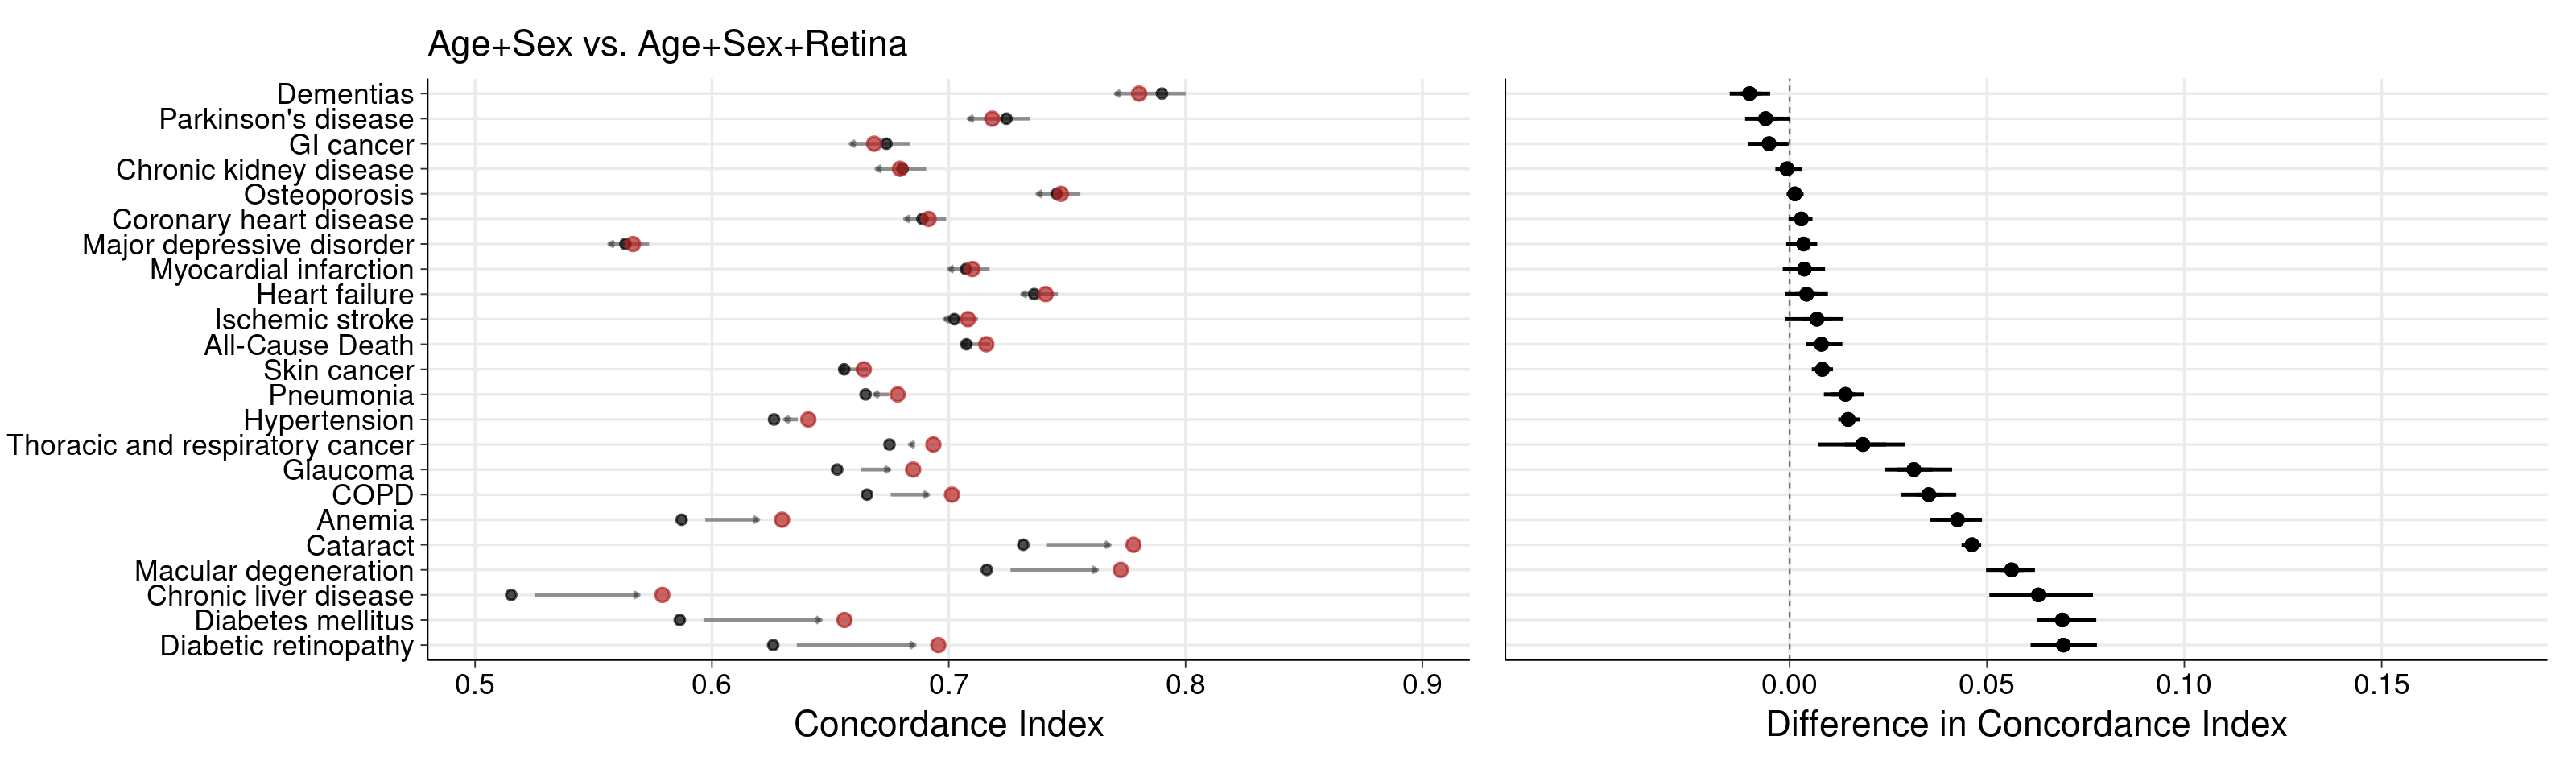

In [24]:
plot_width = 10; plot_height=3; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)

fig1 = plot_against_score("Age+Sex", "Age+Sex+Retina")  
fig1

In [25]:
endpoints_cardio = c(
#     'phecode_431-11', #  "Cerebral infarction [Ischemic stroke]",
#     'phecode_404', #  "Ischemic heart disease",
#     'phecode_404-1', #  "Myocardial infarction [Heart attack]", # intervention
#     'phecode_424', #  "Heart failure", # intervention
#      'OMOP_4306655', #  "All-Cause Death", # intervention
#     'phecode_420', #  "Cardiac arrest", # intervention
#     'phecode_059-1' # COVID
   
# )


    'phecode_431-11', #  "Cerebral infarction [Ischemic stroke]",
    'phecode_404', #  "Ischemic heart disease",
    'phecode_404-1', #  "Myocardial infarction [Heart attack]", # intervention
    'phecode_424', #  "Heart failure", # intervention
    'OMOP_4306655' #  "All-Cause Death", # intervention
#     'phecode_420' #  "Cardiac arrest", # intervention 
#     "phecode_375-1", # Glaucoma
#     "phecode_374-42", # Diabetic retinopathy
#     "phecode_202", # Diabetes mellitus
#     "phecode_401",	#Hypertension"  
#     "phecode_103", # Malignant neoplasm of the skin
#    'phecode_059-1' #  "COVID",
    )

In [26]:
plot_width = 10; plot_height=4; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)

library(ggtext)

In [27]:
#plot_width = 8.75; plot_height=4; plot_res = 320
plot_width = 8.75; plot_height=4; plot_res = 320

options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)


fig1 = plot_against_score("Age+Sex", "Age+Sex+Retina", endpoints_cardio)

fig2 = plot_against_score("SCORE2", "Age+Sex+Retina", endpoints_cardio) 
fig3 = plot_against_score("ASCVD", "Age+Sex+Retina", endpoints_cardio)
fig4 = plot_against_score("QRISK3", "Age+Sex+Retina", endpoints_cardio) 

fig5 = plot_against_score("SCORE2", "SCORE2+Retina", endpoints_cardio) 
fig6 = plot_against_score("ASCVD", "ASCVD+Retina", endpoints_cardio)
fig7 = plot_against_score("QRISK3", "QRISK3+Retina", endpoints_cardio) 

In [28]:
#fig1/fig2/fig3/fig4 
fig3c = fig2/fig3/fig4 
fig3d = fig5/fig6/fig7 &theme(axis.text.y = element_blank())

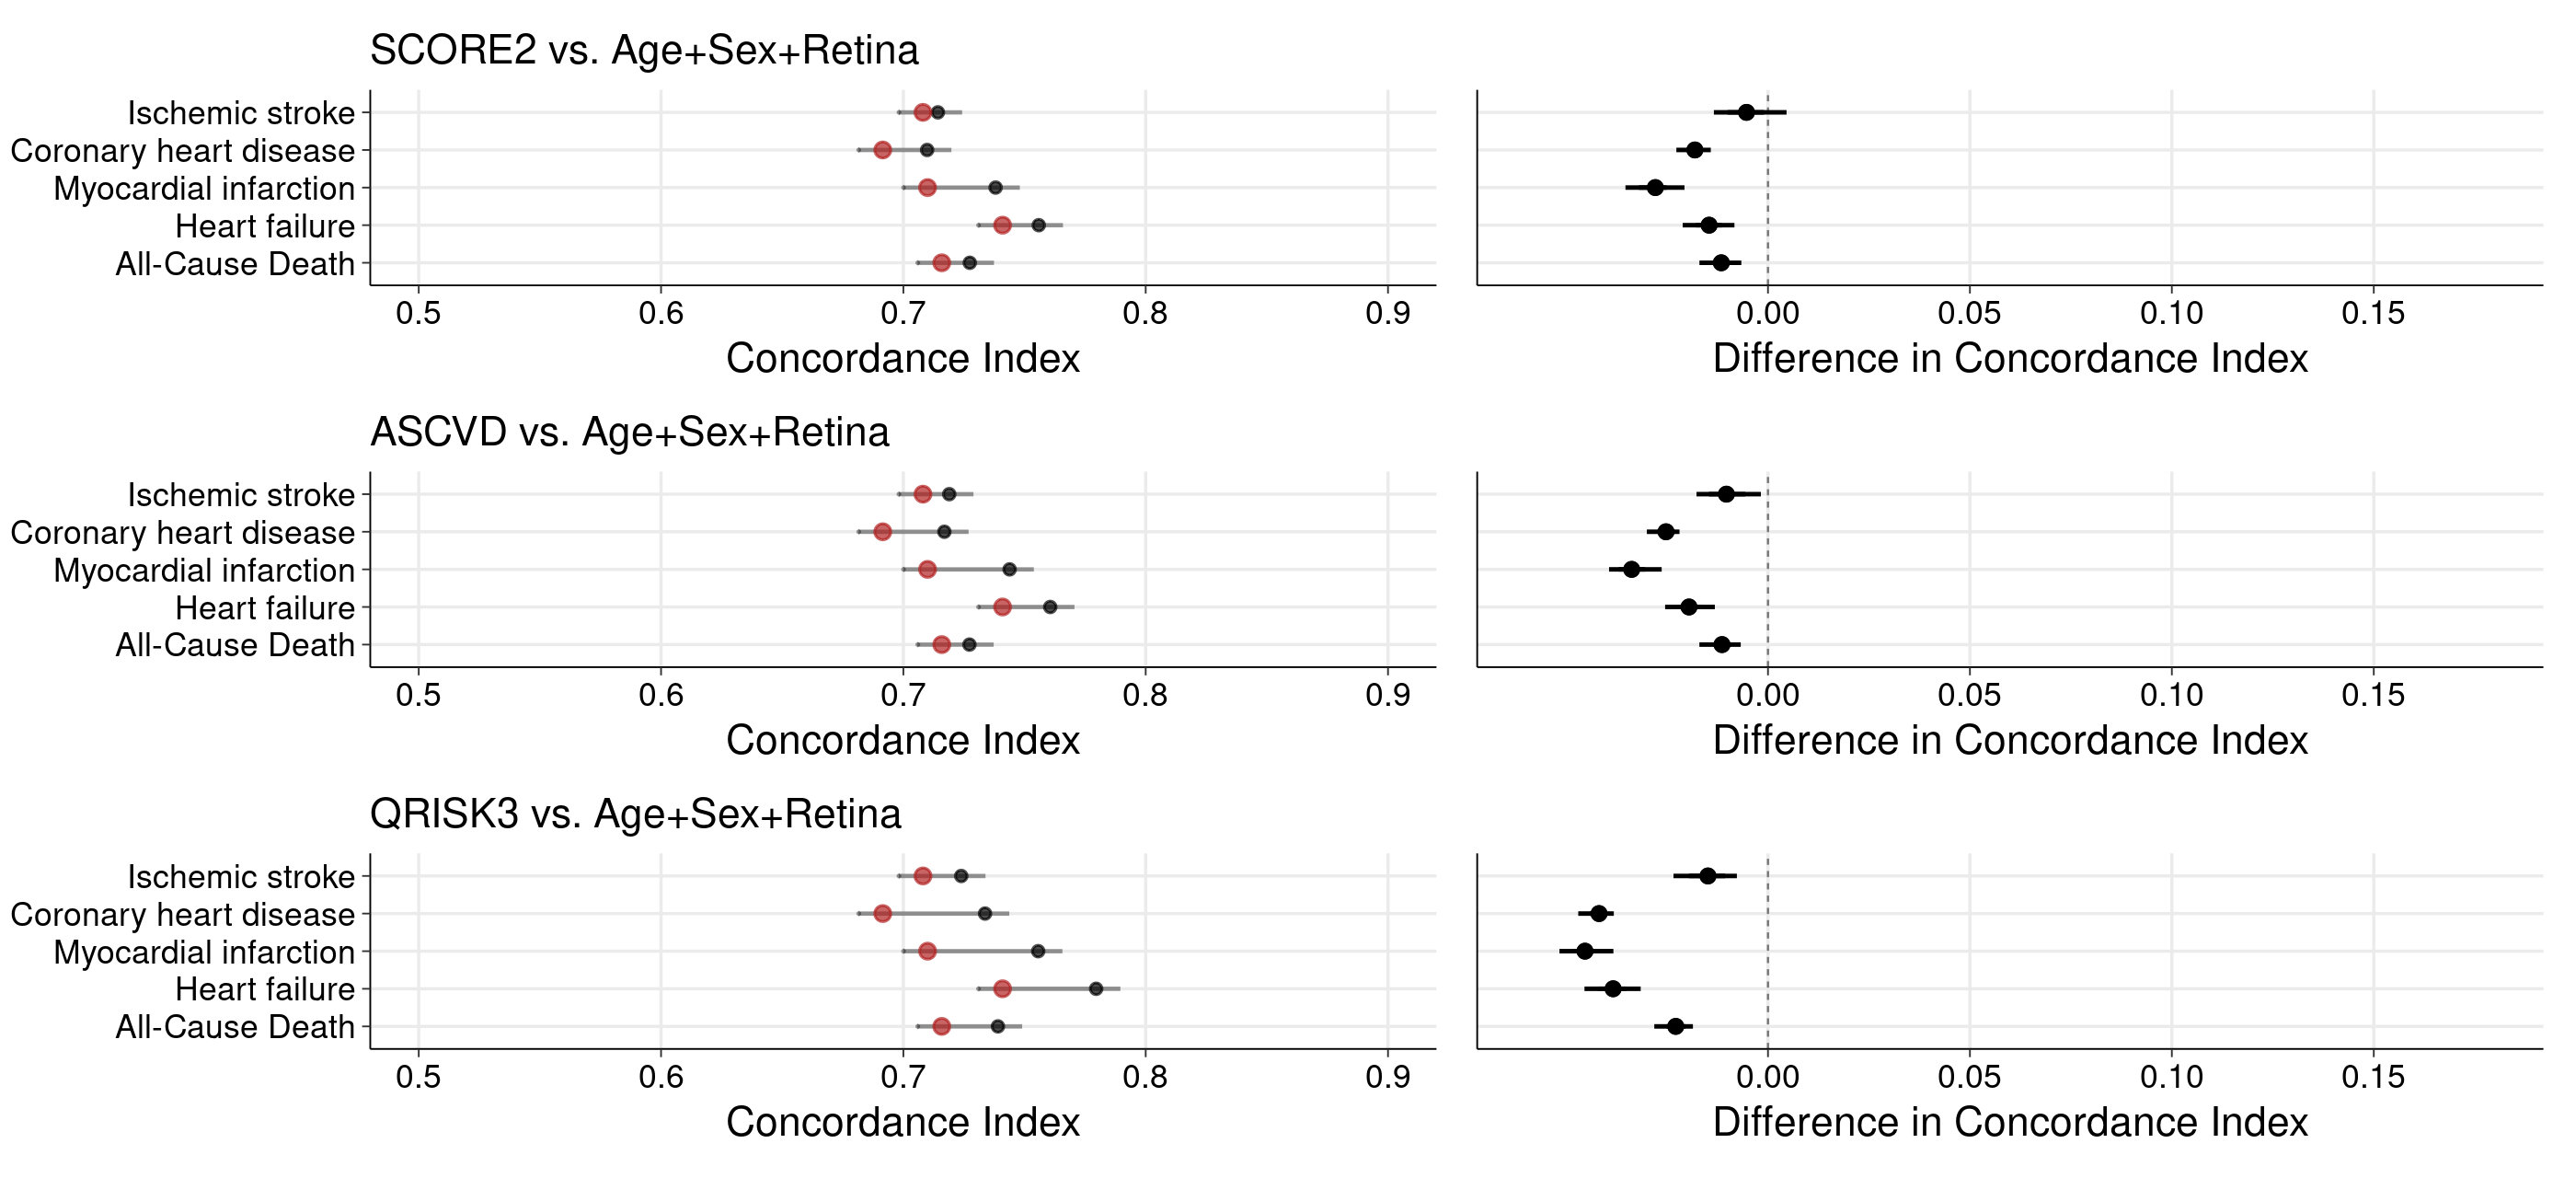

In [29]:
plot_width = 8.75; plot_height=4; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
fig3c

In [30]:
plot_name = "Figure3c_Discrimination_CVD"
fig3c %>% ggsave(filename=glue("outputs/{plot_name}.pdf"), device="pdf", width=plot_width, height=plot_height, dpi=plot_res, limitsize=FALSE)
fig3c %>% ggsave(filename=glue("outputs/{plot_name}.png"), device="png", width=plot_width, height=plot_height, dpi=plot_res, limitsize=FALSE)

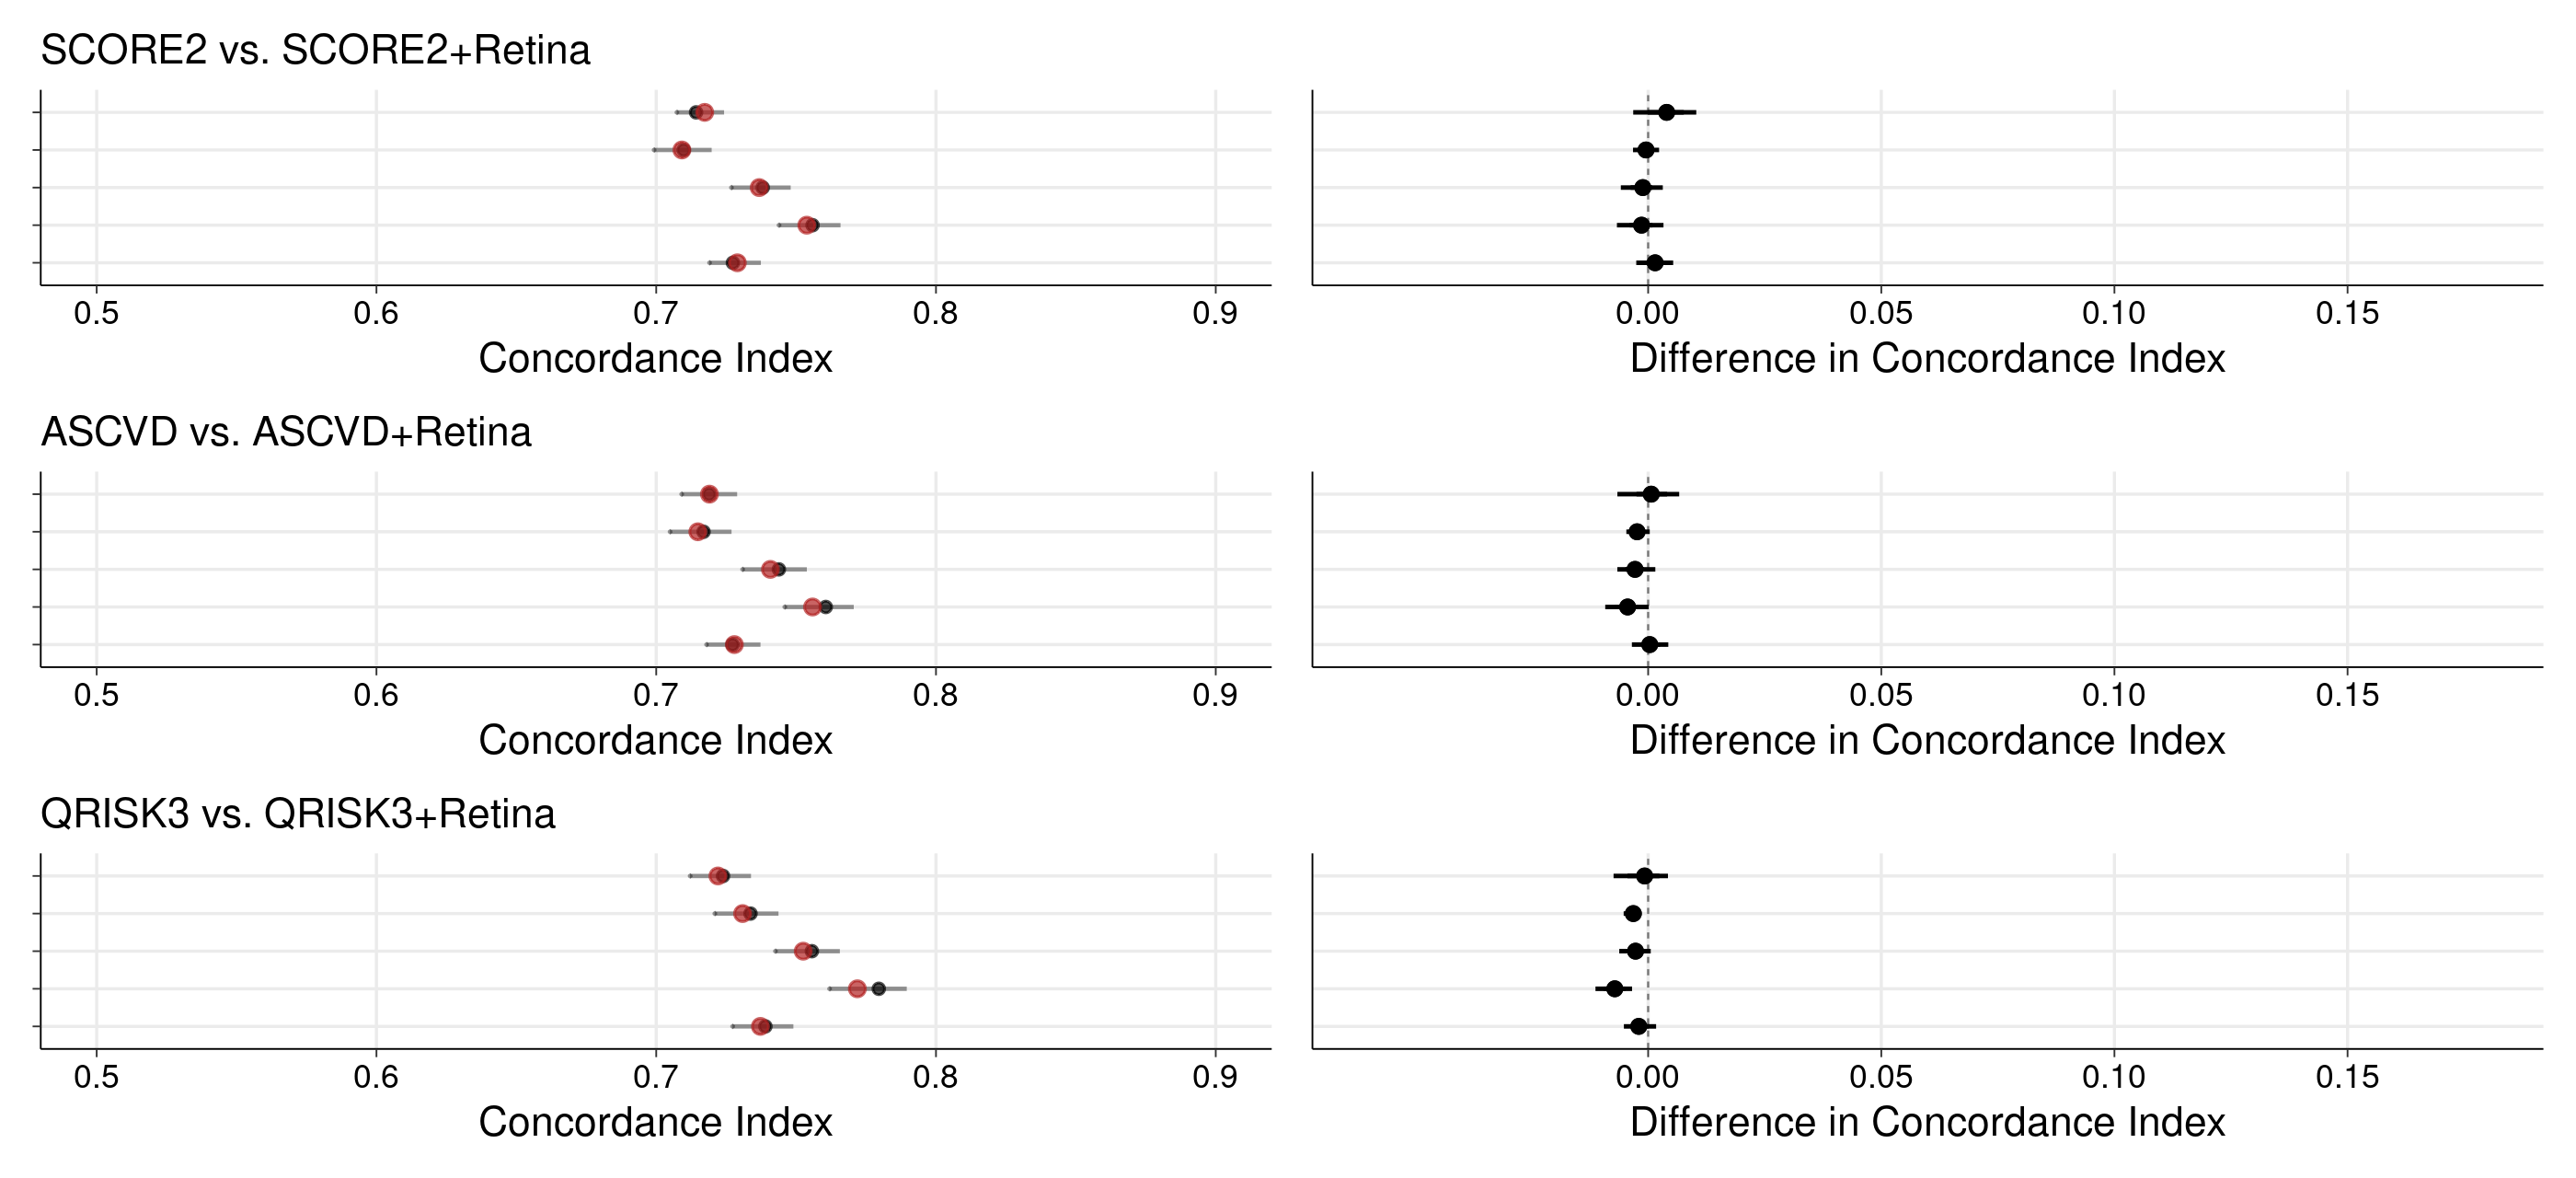

In [31]:
#plot_width = 8.75; plot_height=4; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
fig3d

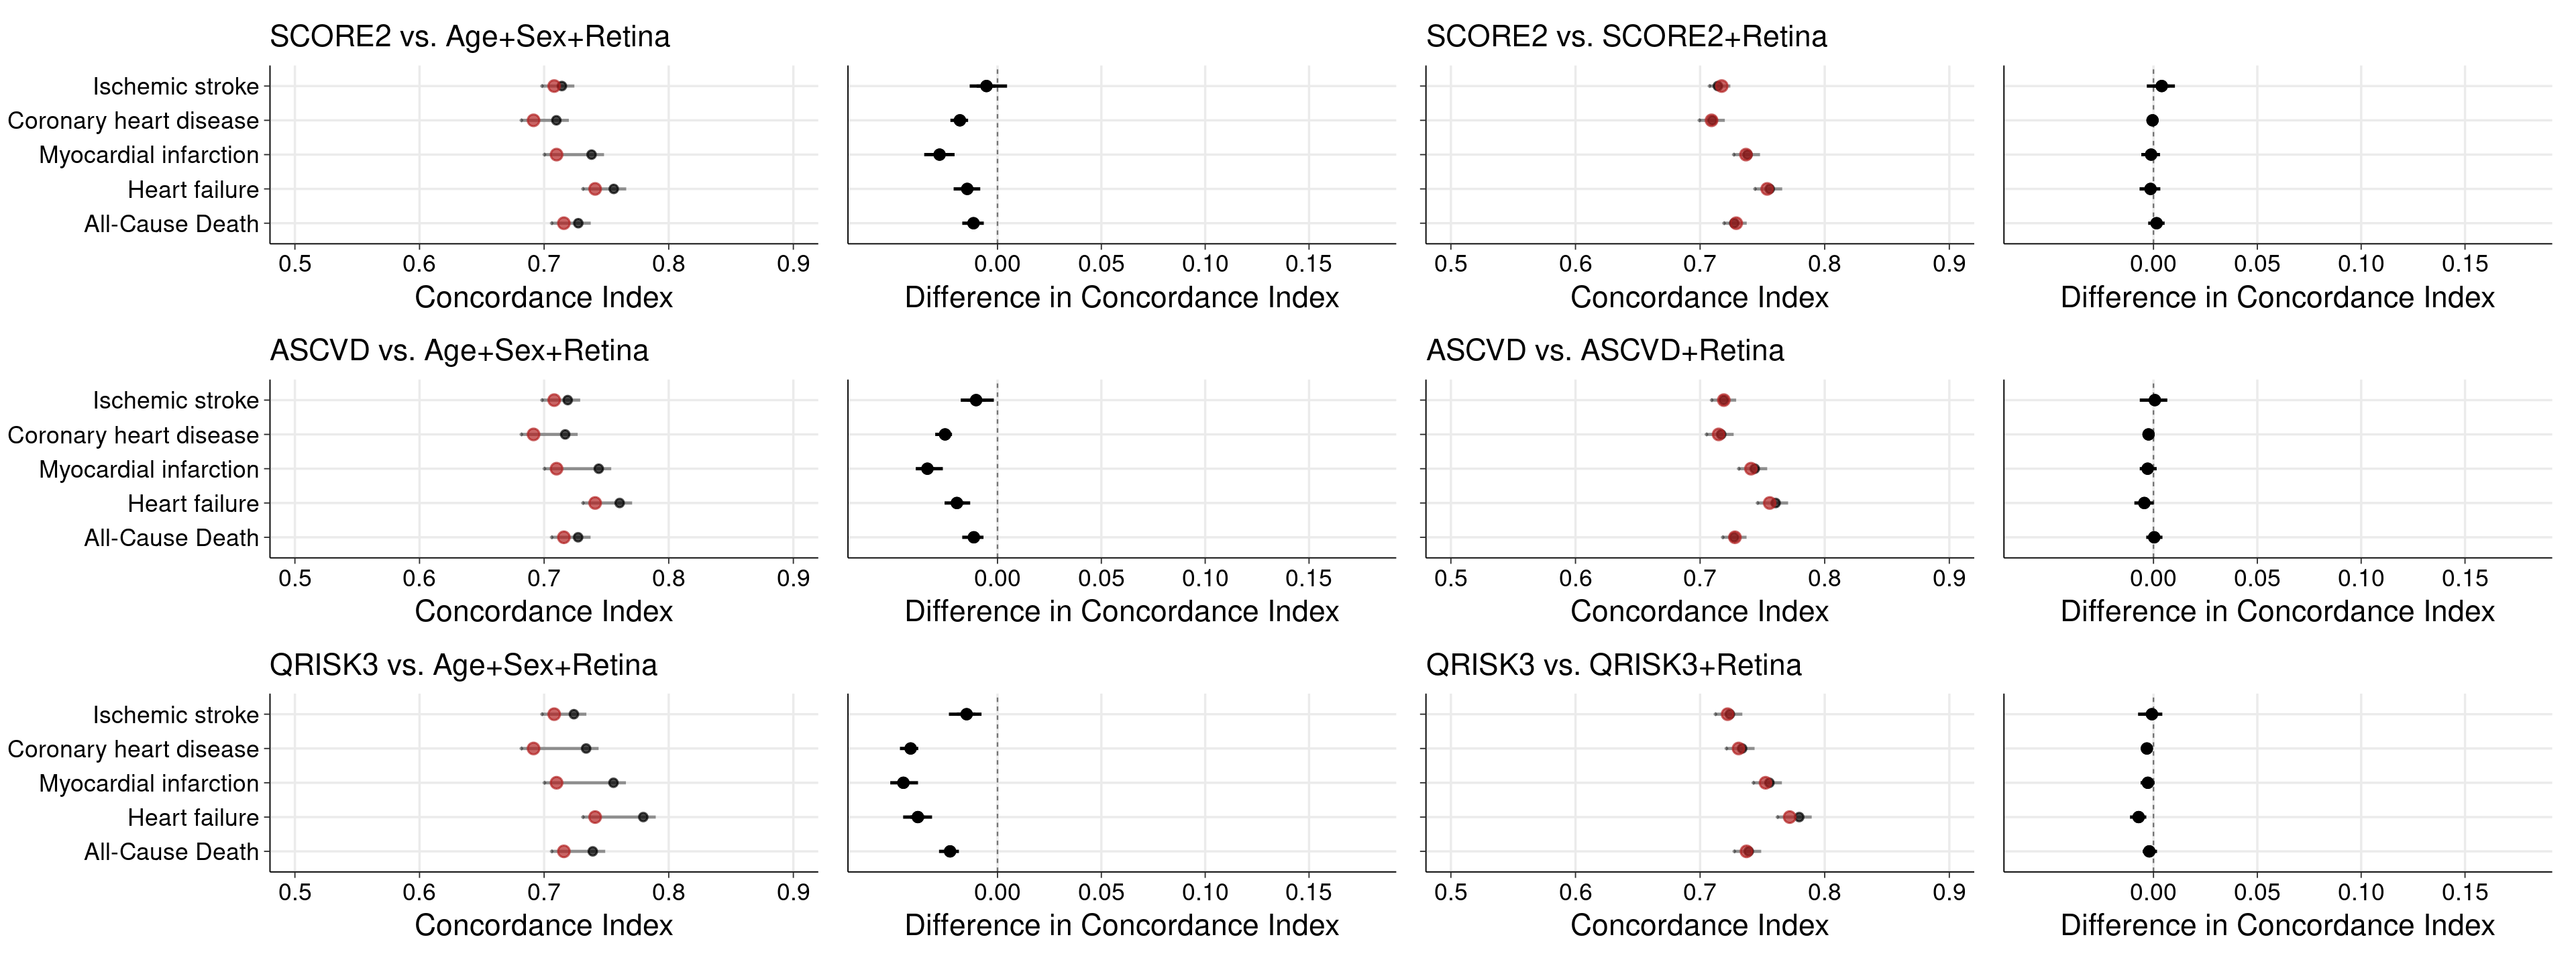

In [32]:
design = "
a
b
c
d
e
f"
plot_width = 12; plot_height=4.5; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
fig3 = (fig3c | fig3d) + plot_layout(widths=c(0.5, 0.5))#design=design)
fig3

In [33]:
plot_name = "Figure3cd_CVDadd"
fig3 %>% ggsave(filename=glue("outputs/{plot_name}.pdf"), device="pdf", width=plot_width, height=plot_height, dpi=plot_res, limitsize=FALSE)
fig3 %>% ggsave(filename=glue("outputs/{plot_name}.png"), device="png", width=plot_width, height=plot_height, dpi=plot_res, limitsize=FALSE)

## SupplTable 7 UKB

In [34]:
score1="Age+Sex"
score2="Age+Sex+Retina"

scores_plot = c(score1, score2)
temp_base = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    filter(endpoint %in% endpoints_cardio) %>%
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    #ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = !!sym(score2)-!!sym(score1)) %>%
    #mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    select(endpoint, iteration, phecode_string, phecode_category, sex, score1, score2, delta) %>%
    pivot_longer(all_of(c(score1, score2, "delta")), names_to="type", values_to="cindex") %>%
    group_by(endpoint, phecode_string, phecode_category, type) %>%
    median_qi(cindex) %>% 
    pivot_wider(names_from=type, values_from=cindex) %>%
    select(phecode_string, `.lower`, `.upper`, delta) %>% 
    drop_na() %>%
    mutate(score = glue("{score1} vs. {score2}"))

score1="SCORE2"
score2="SCORE2+Retina"

scores_plot = c(score1, score2)
temp_score = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    filter(endpoint %in% endpoints_cardio) %>%
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    #ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = !!sym(score2)-!!sym(score1)) %>%
    #mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    select(endpoint, iteration, phecode_string, phecode_category, sex, score1, score2, delta) %>%
    pivot_longer(all_of(c(score1, score2, "delta")), names_to="type", values_to="cindex") %>%
    group_by(endpoint, phecode_string, phecode_category, type) %>%
    median_qi(cindex) %>% 
    pivot_wider(names_from=type, values_from=cindex) %>%
    select(phecode_string, `.lower`, `.upper`, delta) %>% 
    drop_na() %>%
    mutate(score = glue("{score1} vs. {score2}"))

score1="ASCVD"
score2="ASCVD+Retina"

scores_plot = c(score1, score2)
temp_ascvd = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    filter(endpoint %in% endpoints_cardio) %>%
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    #ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = !!sym(score2)-!!sym(score1)) %>%
    #mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    select(endpoint, iteration, phecode_string, phecode_category, sex, score1, score2, delta) %>%
    pivot_longer(all_of(c(score1, score2, "delta")), names_to="type", values_to="cindex") %>%
    group_by(endpoint, phecode_string, phecode_category, type) %>%
    median_qi(cindex) %>% 
    pivot_wider(names_from=type, values_from=cindex) %>%
    select(phecode_string, `.lower`, `.upper`, delta) %>% 
    drop_na() %>%
    mutate(score = glue("{score1} vs. {score2}"))

score1="QRISK3"
score2="QRISK3+Retina"

scores_plot = c(score1, score2)
temp_qrisk = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    filter(endpoint %in% endpoints_cardio) %>%
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    #ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = !!sym(score2)-!!sym(score1)) %>%
    #mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    select(endpoint, iteration, phecode_string, phecode_category, sex, score1, score2, delta) %>%
    pivot_longer(all_of(c(score1, score2, "delta")), names_to="type", values_to="cindex") %>%
    group_by(endpoint, phecode_string, phecode_category, type) %>%
    median_qi(cindex) %>% 
    pivot_wider(names_from=type, values_from=cindex) %>%
    select(phecode_string, `.lower`, `.upper`, delta) %>% 
    drop_na() %>%
    mutate(score = glue("{score1} vs. {score2}"))


score1="ASCVD"
score2="Age+Sex+Retina"

scores_plot = c(score1, score2)
temp_retascvd = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    filter(endpoint %in% endpoints_cardio) %>%
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    #ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = !!sym(score2)-!!sym(score1)) %>%
    #mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    select(endpoint, iteration, phecode_string, phecode_category, sex, score1, score2, delta) %>%
    pivot_longer(all_of(c(score1, score2, "delta")), names_to="type", values_to="cindex") %>%
    group_by(endpoint, phecode_string, phecode_category, type) %>%
    median_qi(cindex) %>% 
    pivot_wider(names_from=type, values_from=cindex) %>%
    select(phecode_string, `.lower`, `.upper`, delta) %>% 
    drop_na() %>%
    mutate(score = glue("{score1} vs. {score2}"))


score1="SCORE2"
score2="Age+Sex+Retina"

scores_plot = c(score1, score2)
temp_retscore = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    filter(endpoint %in% endpoints_cardio) %>%
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    #ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = !!sym(score2)-!!sym(score1)) %>%
    #mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    select(endpoint, iteration, phecode_string, phecode_category, sex, score1, score2, delta) %>%
    pivot_longer(all_of(c(score1, score2, "delta")), names_to="type", values_to="cindex") %>%
    group_by(endpoint, phecode_string, phecode_category, type) %>%
    median_qi(cindex) %>% 
    pivot_wider(names_from=type, values_from=cindex) %>%
    select(phecode_string, `.lower`, `.upper`, delta) %>% 
    drop_na() %>%
    mutate(score = glue("{score1} vs. {score2}"))

score1="QRISK3"
score2="Age+Sex+Retina"

scores_plot = c(score1, score2)
temp_retqrisk= benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    filter(endpoint %in% endpoints_cardio) %>%
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    #ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = !!sym(score2)-!!sym(score1)) %>%
    #mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    select(endpoint, iteration, phecode_string, phecode_category, sex, score1, score2, delta) %>%
    pivot_longer(all_of(c(score1, score2, "delta")), names_to="type", values_to="cindex") %>%
    group_by(endpoint, phecode_string, phecode_category, type) %>%
    median_qi(cindex) %>% 
    pivot_wider(names_from=type, values_from=cindex) %>%
    select(phecode_string, `.lower`, `.upper`, delta) %>% 
    drop_na() %>%
    mutate(score = glue("{score1} vs. {score2}"))

all = bind_rows(temp_base,
                temp_score, 
                temp_ascvd, 
                temp_qrisk,
                temp_retscore,
                temp_retascvd,
                temp_retqrisk
               ) %>% arrange(phecode_string)

#%>% filter(delta>0) %>% arrange(desc(`Age+Sex+Retina`))


#     mutate(endpoint = fct_reorder(endpoint, delta)) %>%
#     mutate(highlight = case_when(endpoint %in% endpoints_cardio ~ "YES", TRUE ~ "NO")) %>%# %>% filter(endpoint %in% endpoint_sample)
#     mutate(phecode_category = factor(phecode_category, levels=categories_sorted)) %>%




#     group_by(endpoint, score, phecode_string, phecode_category) %>%
#     pivot_wider(names_from=score, values_from=cindex) %>% 
#     mutate(id = row_number()) %>%
#     mutate(delta = `Age+Sex+Retina`-`Age+Sex`) %>%
#     pivot_longer(all_of(c("Age+Sex", "Age+Sex+Retina", "delta")), names_to="type", values_to="cindex") %>%
#     group_by(endpoint, phecode_string, phecode_category, type) %>%
#     median_qi(cindex) %>% 
# ungroup() %>%
  
#select(phecode_string, score1, `Age+Sex`, delta) #%>% filter(delta>0) %>% arrange(desc(`Age+Sex+Retina`))

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(score1)` instead of `score1` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(score2)` instead of `score2` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



In [35]:
endpoints_cardio

[1] "phecode_431-11" "phecode_404"    "phecode_404-1"  "phecode_424"   
[5] "OMOP_4306655"

In [36]:
options(repr.matrix.max.cols=150, repr.matrix.max.rows=500)
all %>% write_csv(glue("outputs/ST7_UKB.csv"))
all

phecode_string,.lower,.upper,delta,score
<chr>,<dbl>,<dbl>,<dbl>,<glue>
All-Cause Death,0.0040806932,0.0133742043,0.0080582861,Age+Sex vs. Age+Sex+Retina
All-Cause Death,-0.0025504653,0.0053665957,0.0014945988,SCORE2 vs. SCORE2+Retina
All-Cause Death,-0.0034905179,0.0043160882,0.0003444789,ASCVD vs. ASCVD+Retina
All-Cause Death,-0.0052055120,0.0017050973,-0.0020130814,QRISK3 vs. QRISK3+Retina
All-Cause Death,-0.0169773814,-0.0066020322,-0.0115595546,SCORE2 vs. Age+Sex+Retina
All-Cause Death,-0.0169883666,-0.0067479570,-0.0113894523,ASCVD vs. Age+Sex+Retina
All-Cause Death,-0.0281552490,-0.0185857776,-0.0228371240,QRISK3 vs. Age+Sex+Retina
Cerebral infarction [Ischemic stroke],-0.0012060844,0.0134880384,0.0069098512,Age+Sex vs. Age+Sex+Retina
Cerebral infarction [Ischemic stroke],-0.0032045822,0.0103194017,0.0039744683,SCORE2 vs. SCORE2+Retina


## SupplTable 7 EPIC

In [91]:
score1="Age+Sex"
score2="Age+Sex+Retina"

scores_plot = c(score1, score2)
temp_base = benchmark_endpoints_epic %>% 
    filter(score %in% scores_plot) %>% 
    filter(endpoint %in% endpoints_cardio) %>%
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    #ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = !!sym(score2)-!!sym(score1)) %>%
    #mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    select(endpoint, iteration, phecode_string, phecode_category, sex, score1, score2, delta) %>%
    pivot_longer(all_of(c(score1, score2, "delta")), names_to="type", values_to="cindex") %>%
    group_by(endpoint, phecode_string, phecode_category, type) %>%
    median_qi(cindex) %>% 
    pivot_wider(names_from=type, values_from=cindex) %>%
    select(phecode_string, `.lower`, `.upper`, delta) %>% 
    drop_na() %>%
    mutate(score = glue("{score1} vs. {score2}"))

score1="SCORE2"
score2="SCORE2+Retina"

scores_plot = c(score1, score2)
temp_score = benchmark_endpoints_epic %>% 
    filter(score %in% scores_plot) %>% 
    filter(endpoint %in% endpoints_cardio) %>%
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    #ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = !!sym(score2)-!!sym(score1)) %>%
    #mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    select(endpoint, iteration, phecode_string, phecode_category, sex, score1, score2, delta) %>%
    pivot_longer(all_of(c(score1, score2, "delta")), names_to="type", values_to="cindex") %>%
    group_by(endpoint, phecode_string, phecode_category, type) %>%
    median_qi(cindex) %>% 
    pivot_wider(names_from=type, values_from=cindex) %>%
    select(phecode_string, `.lower`, `.upper`, delta) %>% 
    drop_na() %>%
    mutate(score = glue("{score1} vs. {score2}"))

score1="ASCVD"
score2="ASCVD+Retina"

scores_plot = c(score1, score2)
temp_ascvd = benchmark_endpoints_epic %>% 
    filter(score %in% scores_plot) %>% 
    filter(endpoint %in% endpoints_cardio) %>%
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    #ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = !!sym(score2)-!!sym(score1)) %>%
    #mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    select(endpoint, iteration, phecode_string, phecode_category, sex, score1, score2, delta) %>%
    pivot_longer(all_of(c(score1, score2, "delta")), names_to="type", values_to="cindex") %>%
    group_by(endpoint, phecode_string, phecode_category, type) %>%
    median_qi(cindex) %>% 
    pivot_wider(names_from=type, values_from=cindex) %>%
    select(phecode_string, `.lower`, `.upper`, delta) %>% 
    drop_na() %>%
    mutate(score = glue("{score1} vs. {score2}"))


score1="ASCVD"
score2="Age+Sex+Retina"

scores_plot = c(score1, score2)
temp_retascvd = benchmark_endpoints_epic %>% 
    filter(score %in% scores_plot) %>% 
    filter(endpoint %in% endpoints_cardio) %>%
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    #ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = !!sym(score2)-!!sym(score1)) %>%
    #mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    select(endpoint, iteration, phecode_string, phecode_category, sex, score1, score2, delta) %>%
    pivot_longer(all_of(c(score1, score2, "delta")), names_to="type", values_to="cindex") %>%
    group_by(endpoint, phecode_string, phecode_category, type) %>%
    median_qi(cindex) %>% 
    pivot_wider(names_from=type, values_from=cindex) %>%
    select(phecode_string, `.lower`, `.upper`, delta) %>% 
    drop_na() %>%
    mutate(score = glue("{score1} vs. {score2}"))


score1="SCORE2"
score2="Age+Sex+Retina"

scores_plot = c(score1, score2)
temp_retscore = benchmark_endpoints_epic %>% 
    filter(score %in% scores_plot) %>% 
    filter(endpoint %in% endpoints_cardio) %>%
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    #ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = !!sym(score2)-!!sym(score1)) %>%
    #mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    select(endpoint, iteration, phecode_string, phecode_category, sex, score1, score2, delta) %>%
    pivot_longer(all_of(c(score1, score2, "delta")), names_to="type", values_to="cindex") %>%
    group_by(endpoint, phecode_string, phecode_category, type) %>%
    median_qi(cindex) %>% 
    pivot_wider(names_from=type, values_from=cindex) %>%
    select(phecode_string, `.lower`, `.upper`, delta) %>% 
    drop_na() %>%
    mutate(score = glue("{score1} vs. {score2}"))

all_epic = bind_rows(temp_base,
                temp_score, 
                temp_ascvd, 
                #temp_qrisk,
                temp_retscore,
                temp_retascvd,
                #temp_retqrisk
               ) %>% arrange(phecode_string)

#%>% filter(delta>0) %>% arrange(desc(`Age+Sex+Retina`))


#     mutate(endpoint = fct_reorder(endpoint, delta)) %>%
#     mutate(highlight = case_when(endpoint %in% endpoints_cardio ~ "YES", TRUE ~ "NO")) %>%# %>% filter(endpoint %in% endpoint_sample)
#     mutate(phecode_category = factor(phecode_category, levels=categories_sorted)) %>%




#     group_by(endpoint, score, phecode_string, phecode_category) %>%
#     pivot_wider(names_from=score, values_from=cindex) %>% 
#     mutate(id = row_number()) %>%
#     mutate(delta = `Age+Sex+Retina`-`Age+Sex`) %>%
#     pivot_longer(all_of(c("Age+Sex", "Age+Sex+Retina", "delta")), names_to="type", values_to="cindex") %>%
#     group_by(endpoint, phecode_string, phecode_category, type) %>%
#     median_qi(cindex) %>% 
# ungroup() %>%
  
#select(phecode_string, score1, `Age+Sex`, delta) #%>% filter(delta>0) %>% arrange(desc(`Age+Sex+Retina`))

In [92]:
endpoints_cardio

[1] "phecode_431-11" "phecode_404"    "phecode_404-1"  "phecode_424"   
[5] "OMOP_4306655"

In [93]:
options(repr.matrix.max.cols=150, repr.matrix.max.rows=500)
all_epic %>% write_csv(glue("outputs/ST7_EPIC.csv"))
all_epic

phecode_string,.lower,.upper,delta,score
<chr>,<dbl>,<dbl>,<dbl>,<glue>
All-Cause Death,-1.523842e-02,0.0080278277,-6.053008e-03,Age+Sex vs. Age+Sex+Retina
All-Cause Death,-1.136126e-02,0.0175717763,-2.904228e-03,SCORE2 vs. SCORE2+Retina
All-Cause Death,-1.489644e-02,0.0146798364,-3.739370e-03,ASCVD vs. ASCVD+Retina
All-Cause Death,-8.642782e-03,0.0421921428,1.067488e-02,SCORE2 vs. Age+Sex+Retina
All-Cause Death,-2.353906e-02,0.0321755078,7.046176e-03,ASCVD vs. Age+Sex+Retina
Cerebral infarction [Ischemic stroke],-3.322126e-03,0.0048365045,1.790922e-04,Age+Sex vs. Age+Sex+Retina
Cerebral infarction [Ischemic stroke],-6.153848e-03,0.0027294606,-2.207600e-03,SCORE2 vs. SCORE2+Retina
Cerebral infarction [Ischemic stroke],-5.450605e-03,0.0035948346,-1.870030e-03,ASCVD vs. ASCVD+Retina
Cerebral infarction [Ischemic stroke],-1.349110e-02,-0.0007473130,-1.021109e-02,SCORE2 vs. Age+Sex+Retina


## merge UKB and EPIC

In [94]:
colnames(all_epic)[2:4] = glue("epic_{colnames(all_epic)[2:4]}")
all_epic

phecode_string,epic_.lower,epic_.upper,epic_delta,score
<chr>,<dbl>,<dbl>,<dbl>,<glue>
All-Cause Death,-1.523842e-02,0.0080278277,-6.053008e-03,Age+Sex vs. Age+Sex+Retina
All-Cause Death,-1.136126e-02,0.0175717763,-2.904228e-03,SCORE2 vs. SCORE2+Retina
All-Cause Death,-1.489644e-02,0.0146798364,-3.739370e-03,ASCVD vs. ASCVD+Retina
All-Cause Death,-8.642782e-03,0.0421921428,1.067488e-02,SCORE2 vs. Age+Sex+Retina
All-Cause Death,-2.353906e-02,0.0321755078,7.046176e-03,ASCVD vs. Age+Sex+Retina
Cerebral infarction [Ischemic stroke],-3.322126e-03,0.0048365045,1.790922e-04,Age+Sex vs. Age+Sex+Retina
Cerebral infarction [Ischemic stroke],-6.153848e-03,0.0027294606,-2.207600e-03,SCORE2 vs. SCORE2+Retina
Cerebral infarction [Ischemic stroke],-5.450605e-03,0.0035948346,-1.870030e-03,ASCVD vs. ASCVD+Retina
Cerebral infarction [Ischemic stroke],-1.349110e-02,-0.0007473130,-1.021109e-02,SCORE2 vs. Age+Sex+Retina


In [95]:
colnames(all)[2:4] = glue("ukb_{colnames(all)[2:4]}")
all

phecode_string,ukb_.lower,ukb_.upper,ukb_delta,score
<chr>,<dbl>,<dbl>,<dbl>,<glue>
All-Cause Death,0.0046841374,0.0098935550,0.0072888462,Age+Sex vs. Age+Sex+Retina
All-Cause Death,-0.0008283553,0.0021801616,0.0006759031,SCORE2 vs. SCORE2+Retina
All-Cause Death,-0.0027538559,0.0007612333,-0.0009963113,ASCVD vs. ASCVD+Retina
All-Cause Death,-0.0048611082,-0.0019423661,-0.0034017372,QRISK3 vs. QRISK3+Retina
All-Cause Death,-0.0120912979,-0.0105837654,-0.0113375316,SCORE2 vs. Age+Sex+Retina
All-Cause Death,-0.0128909101,-0.0109980385,-0.0119444743,ASCVD vs. Age+Sex+Retina
All-Cause Death,-0.0269961703,-0.0244802104,-0.0257381903,QRISK3 vs. Age+Sex+Retina
Cerebral infarction [Ischemic stroke],0.0072994229,0.0128301814,0.0100648021,Age+Sex vs. Age+Sex+Retina
Cerebral infarction [Ischemic stroke],0.0024812305,0.0069109892,0.0046961099,SCORE2 vs. SCORE2+Retina


In [96]:
st7_merged = all %>% left_join(all_epic, by=c("score", "phecode_string"))
st7_merged %>% write_csv(glue("outputs/ST7_merged.csv"))